In [1]:
import re
import os
import sys
import numpy as np
import pandas as pd
from PIL import Image
import scipy.io
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D
import datetime

In [ ]:
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [ ]:
os.environ["CUDA_VISIBLE_DEVICES"]=""

# Load Data


In [2]:
# Laden der vorverarbeiteten Daten von Choy et al.
def construct_file_path_list_from_dir(dir, file_filter):
    if isinstance(file_filter, str):
        file_filter = [file_filter]
    paths = [[] for _ in range(len(file_filter))]

    for root, _, files in os.walk(dir):
        for f_name in files:
            for i, f_substr in enumerate(file_filter):
                if f_substr in f_name:
                    (paths[i]).append(root + '/' + f_name)

    for i, p in enumerate(paths):
        paths[i] = natsorted(p)

    if len(file_filter) == 1:
        return paths[0]

    return tuple(paths)

def load_preprocessed_dataset():
    data_preprocessed_dir = "data_preprocessed"
    
    data_all = sorted(construct_file_path_list_from_dir(data_preprocessed_dir, ["_x.npy"]))
    
    label_all = sorted(construct_file_path_list_from_dir(data_preprocessed_dir, ["_y.npy"]))
    
    return np.array(data_all), np.array(label_all)

In [3]:
data, label = load_preprocessed_dataset()
print(data)

In [4]:
def train_val_test_split(data, label, split=0.1):
   # Split der Daten in Trainings und Testdaten
    X_train, X_test, y_train, y_test = model_selection.train_test_split(
        data, label, test_size=split)  
    # Weiteres Splitten der Trainingsdaten in Validationdaten
    X_train, X_val, y_train, y_val = model_selection.train_test_split(
        X_train, y_train, test_size=split) 

    return X_train, y_train, X_val, y_val, X_test, y_test

# Geteilstes Dataset (immer noch in URLs)
X_train, y_train, X_val, y_val, X_test, y_test = train_val_test_split(data, label)

# Laden der Daten in Batches - Custom Generator

In [5]:
# Hilfsfunktion, um Numpy-Daten in den 
def load_npy(npy_path):
    ret = []
    for p in npy_path:
        ret.append(np.load(p))
    return np.stack(ret)

In [6]:
class Batch_Load_Generator(keras.utils.Sequence) :

    def __init__(self, X, y, batch_size) :
        self.X = X
        self.y = y
        self.batch_size = batch_size


    def __len__(self) :
        return (np.ceil(len(self.X) * 24 / float(self.batch_size * 24))).astype(np.int)

    # Laden der Trainingsdaten aus den Numpy-Dateien in Batches
    def __getitem__(self, idx) :
        batch_x = self.X[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.y[idx * self.batch_size : (idx+1) * self.batch_size]
        
        
        output_X = []
        output_y = []
        
        img_batch_X = load_npy(batch_x)
        
        for index ,imgs in enumerate(img_batch_X):
            for img in imgs:
                img = img[:, :, 0:3]
                img = tf.image.resize(img, [224, 224])
                img = tf.keras.applications.mobilenet.preprocess_input(img)
                output_X.append(img)
                 
                
                vox = np.load(batch_y[index])
                vox = np.argmax(vox, axis=-1)
                vox = vox.transpose(2, 0, 1)
                output_y.append(vox)

        ready_X = []
        ready_X = np.stack(output_X) 
        return (ready_X, np.array(output_y))

# Loss Funktion

In [13]:
def voxel_loss_function(y, y_predicted):    
    return tf.nn.softmax_cross_entropy_with_logits(y, y_predicted)    

# Metric: Eigene IoU

In [14]:
def intersection_over_union(y, y_predicted):
    y_predicted = tf.where(y_predicted >= 1, 1, 0)
    
    m = tf.keras.metrics.MeanIoU(num_classes=2)
    m.update_state(y, y_predicted)
    
    return m.result()

# Model

In [11]:
# Modell, mit welchem auf dem Server trainiert wurde
encoder_base = tf.keras.applications.MobileNetV2(input_shape=( 224, 224, 3), include_top=False, weights='imagenet')
for layer in encoder_base.layers[:125]:
    layer.trainable=False
for layer in encoder_base.layers[125:]:
    layer.trainable=True

output = tf.keras.layers.Conv2D(32, (2,2), strides=2, padding='same', activation='relu')(encoder_base.output)
encoder = tf.keras.models.Model(inputs=encoder_base.input, outputs=output)


decoder = tf.keras.Sequential([
    tf.keras.layers.Reshape((8, 8, 8, 1), input_shape=(4, 4, 32)),
    
    
    tf.keras.layers.Conv3DTranspose(16, (3, 3, 3), padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    
    tf.keras.layers.Conv3DTranspose(32, (3, 3, 3), strides= 2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.relu),
    
    tf.keras.layers.Conv3DTranspose(64, (3, 3, 3), strides= 2, padding="same", kernel_initializer=tf.keras.initializers.HeNormal()),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Activation(tf.keras.activations.relu),

    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Conv3DTranspose(1, (3, 3, 3), activation="sigmoid", padding ="same", kernel_initializer=tf.keras.initializers.GlorotNormal()),
    tf.keras.layers.Reshape([32,32,32])
    
])

model = keras.models.Sequential([encoder, decoder])

Model: "mobilenetv2_1.00_128"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_10 (InputLayer)           [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 64, 64, 32)   864         input_10[0][0]                   
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 64, 64, 32)   128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu (ReLU)               (None, 64, 64, 32)   0           bn_Conv1[0][0]                   
_______________________________________________________________________________

ValueError: total size of new array must be unchanged, input_shape = [2, 2, 32], output_shape = [-1, 256]

In [10]:
training_batch_generator = Batch_Load_Generator(X_train, y_train, 1)
valid_batch_generator = Batch_Load_Generator(X_val, y_val, 1)


In [11]:
opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=opt, loss=voxel_loss_function, metrics=[tf.keras.metrics.Accuracy(), intersection_over_union], run_eagerly=True)

In [ ]:
# Fitten, also trainieren, des Modells. Die Batchsize ist auf Größe 24, da 24 Ansichten der einzelnen Objekte existieren und auch so geladen werden

batch_size = 1 * 24
stepts_per_epoch = int(len(X_train)* 24 // batch_size)
validation_steps = int(len(X_val)* 24 // batch_size)

checkpoint_path = "training/weights.{epoch:02d}.h5"


cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)



log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

history = model.fit(training_batch_generator,
                    epochs=1, validation_data=valid_batch_generator,
                    callbacks=[cp_callback, tensorboard_callback])


# Predicten eines einzelnen Testbilds

In [ ]:
img = np.load(X_test[3])[0]
img = img[None, ...]
img = img[:, :, :, 0:3]

predicted = model.predict(img)
predicted = predicted[0]


# Treshold Für Voxel Daten
predicted = np.where(predicted >= 1, 1, 0)

## Predicten mehrerer Testbildeer

In [6]:
from tensorflow.keras.models import load_model
model = load_model('weights.1500_2.h5', custom_objects={"voxel_loss_function": voxel_loss_function, 'intersection_over_union': intersection_over_union})


paths = ["experimente/white_backgrounds/airplane.png", 
         "experimente/white_backgrounds/car.png", 
         "experimente/white_backgrounds/chair.png", 
         "experimente/white_backgrounds/gießkanne.png", 
         "experimente/white_backgrounds/komplex_chair.png", 
         "experimente/real_airplane.png", 
         "experimente/real_car.png", 
         "experimente/real_car_bmw.png", 
         "experimente/real_chair.png",
         "experimente/white_backgrounds/schrank.png", 
         "experimente/white_backgrounds/schraube.png", 
         "experimente/white_backgrounds/tasse.png"]

all_imgs = []

for path in paths:
    path = "data/ShapeNetRendering" + path
    img = np.array(Image.open(path))
    all_imgs.append(img)

for ind, img in enumerate(all_imgs):
    
    img = img[None, ...]
    img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
    img = img[:, :, :, 0:3]
    img = tf.image.resize(img, [224, 224])

    predicted = model.predict(img)
    predicted = predicted[0]
    np.save("experimente/model2/model_" + str(ind), predicted)

In [ ]:
# Dieser Block wurde fir die zeitliche Messung des Predictens genutzt
import time

model = load_model('weights.1500_2.h5', custom_objects={"voxel_loss_function": voxel_loss_function, 'intersection_over_union': intersection_over_union})
start = time.time()
img = np.array(Image.open("experimente/car.png"))
img = img[None, ...]
img = tf.keras.applications.mobilenet_v2.preprocess_input(img)
img = img[:, :, :, 0:3]
img = tf.image.resize(img, [224, 224])

predicted = model.predict(img)
end = time.time()
print((end - start)*1000.0)

# Voxel Visualisierung

D:\Anaconda\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  del sys.path[0]


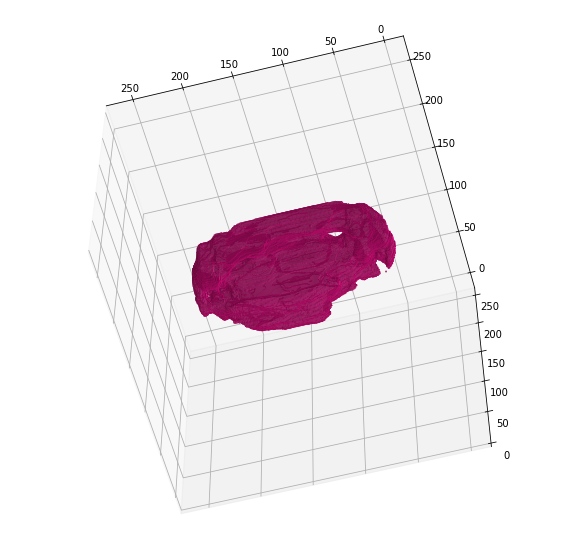

In [9]:
modelimg = "car2"
predicted = np.load('experimente/model2/' + modelimg + '.npy')
predicted = np.where(predicted >= 1, 1, 0)

fig = plt.figure(figsize=(10, 10))
ax = fig.gca(projection='3d')
ax.voxels(predicted, facecolors='deeppink')

# für IM-NET Darstellung
ax.view_init(-60, 105)

# für MobileNet_V2 Darstellung
#ax.view_init(30, 45)

plt.savefig('experimente/model2/' + modelimg + '.png')
fig.show()

# Convertierung des Modells in ein TFLite Modell (Mobil)

In [17]:
# Wichtig: Eigene Funktionalitäten müssen extra angegeben werden
model = load_model('weights.1500_2.h5', custom_objects={"voxel_loss_function": voxel_loss_function, 'intersection_over_union': intersection_over_union})
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS,
  tf.lite.OpsSet.SELECT_TF_OPS
]
tflite_model = converter.convert()

with open('model_2.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\Natalie\AppData\Local\Temp\tmpg439rfep\assets
